# Première approche, le k-nearest neighbors

On va en premier utiliser une approche basique pour classifier nos données : un k-nn classifieur

La bibliothèque scikit learn en propose une implémentation simple d'utilisation. Les paramètres sur lesquels nous jouerons sont le nombre de voisins dans le knn, et la distance utilisée pour rapprocher-éloigner les éléments du datasets.

On utilisera la distance $\ell_p$ metric, avec $p$ à optimiser.

On importe d'abord les bibliothèques utiles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

On récupère ensuite nos données pré-traitées. On choisit un échantillon afin d'optimiser notre modèle. On importe également les fonctions utiles, le modèle et la log-loss, spécifique aux problèmes de classification et qui a été choisie pour évaluer les solutions de cette compétition.

In [2]:
train_data= pd.read_csv('data/pre_processing_train_data.csv')
train_data=train_data.iloc[:,1:]
train_sample = train_data.sample(n=10000)
train_labels=train_sample['Category']
train_sample.drop('Category',inplace =True, axis=1)

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

On va tester un modèle par défaut de k-nn. On sépare nos données labellisées en ensemble de train et de test pour évaluer notre premier modèle.

In [4]:
X = train_sample
y = train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
knn = KNeighborsClassifier(n_neighbors=5, p=1)
knn.fit(X_train, y_train)

p_pred = knn.predict_proba(X_test)

print(" La log-loss de ce modèle est : ", log_loss(y_test,p_pred,labels=y_train.unique()))

 La log-loss de ce modèle est :  21.81672043518077


On procède dorénavant à la cross-validation pour optimiser notre modèle. Les paramètres que nous allons faire varier sont : le nombre de voisins, et la puissance $p$ de la norme de Minkowski. Ces paramètres étant peu liés, on effectue des cross-validation séparées.

In [6]:
def cross_val_knn_k(X,y,k_range=range(1,10)):
    X=np.array(X)
    y=np.array(y)
    nb=len(k_range)
    losses=[]
    for i in range(nb):
        print(k_range[i])
        loss=[]
        knn = KNeighborsClassifier(n_neighbors=k_range[i], p=3)
        for it in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X, y , random_state =it,     test_size=0.25)
            knn.fit(X_train,y_train)
            p_pred = knn.predict_proba(X_test)
            l=log_loss(y_test,p_pred,labels=np.unique(y_train))
            loss.append(l)
        losses.append(loss)
        print(np.mean(loss))
    losses=np.asarray(losses)
    plt.title("Log loss")
    plt.xlabel("Number of neighbours")
    plt.errorbar(k_range,losses.mean(axis=1),losses.std(axis=1))
    plt.show()

def cross_val_knn_p(X,y,p_range=range(1,10)):
    X=np.array(X)
    y=np.array(y)
    nb=len(p_range)
    losses=[]
    for i in range(nb):
        print(p_range[i])
        loss=[]
        knn = KNeighborsClassifier(n_neighbors=100, p=p_range[i])
        for it in range(5):
            X_train, X_test, y_train, y_test = train_test_split(X, y , random_state =it,     test_size=0.25)
            knn.fit(X_train,y_train)
            p_pred = knn.predict_proba(X_test)
            l=log_loss(y_test,p_pred,labels=np.unique(y_train))
            loss.append(l)
        print(np.mean(loss))
        losses.append(loss)
    losses=np.asarray(losses)
    plt.title("Log loss")
    plt.xlabel("Minkowski power distance")
    plt.errorbar(p_range,losses.mean(axis=1),losses.std(axis=1))
    plt.show()

10
15.576338025000936
50
5.852434535378186
100
4.273851352325723
200
3.506159780272977


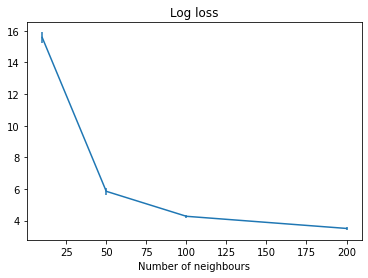

1
4.129346173262087
2
4.243272492247806
3
4.273851352325723
4
4.237598270845029


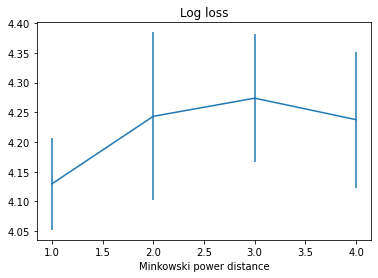

In [7]:
cross_val_knn_k(X,y,k_range=[10,50,100,200])
cross_val_knn_p(X,y,p_range=range(1,5))

On remarque alors qu'on a intérêt à prendre un maximum de voisins pour prédire le meilleur vecteur de probabilité possible. Toutefois l'augmentation du nombre de voisins augmente fortement la complexité de calcul de l'algorithme. Dans le but de prendre en compte tout le dataset de train, le meilleur tradeoff a été de prendre $k=100$ voisins et $p=1$.
On entraine alors notre modèle sur tout le dataset de train. On importe les données pré-traitées de test puis on récupère les probabilités données par le modèle et les enregistre sous la forme exigée par kaggle, pour évauler définitivement notre modèle.

In [ ]:
train_data= pd.read_csv('data/pre_processing_train_data.csv')
train_data=train_data.iloc[:,1:]
train_labels=train_data['Category']
train_data.drop('Category',inplace =True, axis=1)

knn_opt = KNeighborsClassifier(n_neighbors=100, p=1)
knn_opt.fit(train_data, train_labels)

test_data = pd.read_csv('data/pre_processing_test_data.csv')
test_data = test_data.iloc[:,1:]
list_cat=np.load('categories.npy',allow_pickle=True)

p_pred = knn_opt.predict_proba(test_data)
pred= pd.DataFrame (p_pred, columns = list_cat)
pred.to_csv("pred_knn.csv")
pred.head()

En envrion 5 minutes, le modèle de $k$-nn avec $k=100$ voisins nous délivre ses prédictions. Il donne un résultat de 4.26 en log loss et nous place 1700ème sur 2500 au leaderboard du classement de la compétition. Afin d'améliorer ce résultat, nous allons nous pencher sur un modèle de random forest, que l'on pense mieux adapté au problème.